In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from ipyleaflet import Map, CircleMarker
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

main_df = pd.read_csv('../data/processed/PROCESSED_DF.csv')
main_df.head(3)

,id,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365
0,2539,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1.0,9,2018-10-19,0.21,365.0
1,2595,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45,2019-05-21,0.38,355.0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3.0,0,NaN,0.00,365.0


In [2]:
main_df = main_df.drop(['id'], axis=1)
main_df.head(3)

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1.0,9,2018-10-19,0.21,365.0
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45,2019-05-21,0.38,355.0
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3.0,0,NaN,0.00,365.0


<h3>Relación entre el nombre del alojamiento y el número de reviews</h3>

In [3]:
main_df['name_len'] = main_df['name'].str.len()

longer_name = main_df.loc[main_df['name_len'].idxmax()]
shorter_name = main_df.loc[main_df['name_len'].idxmin()]

print(f'Longer name with {longer_name["name_len"]} characters:\n{longer_name["name"]}\n')
print(f'Shorter name with {shorter_name["name_len"]} characters:\n{shorter_name["name"]}\n')

Longer name with 179 characters:
The printing studio bedroom with garden in Bedstuy  !!Brooklyn. Historic neighborhood close to everything ! Full kitchen bathroom BBQ and porch at your disposal. Learn to print !!

Shorter name with 1 characters:
/



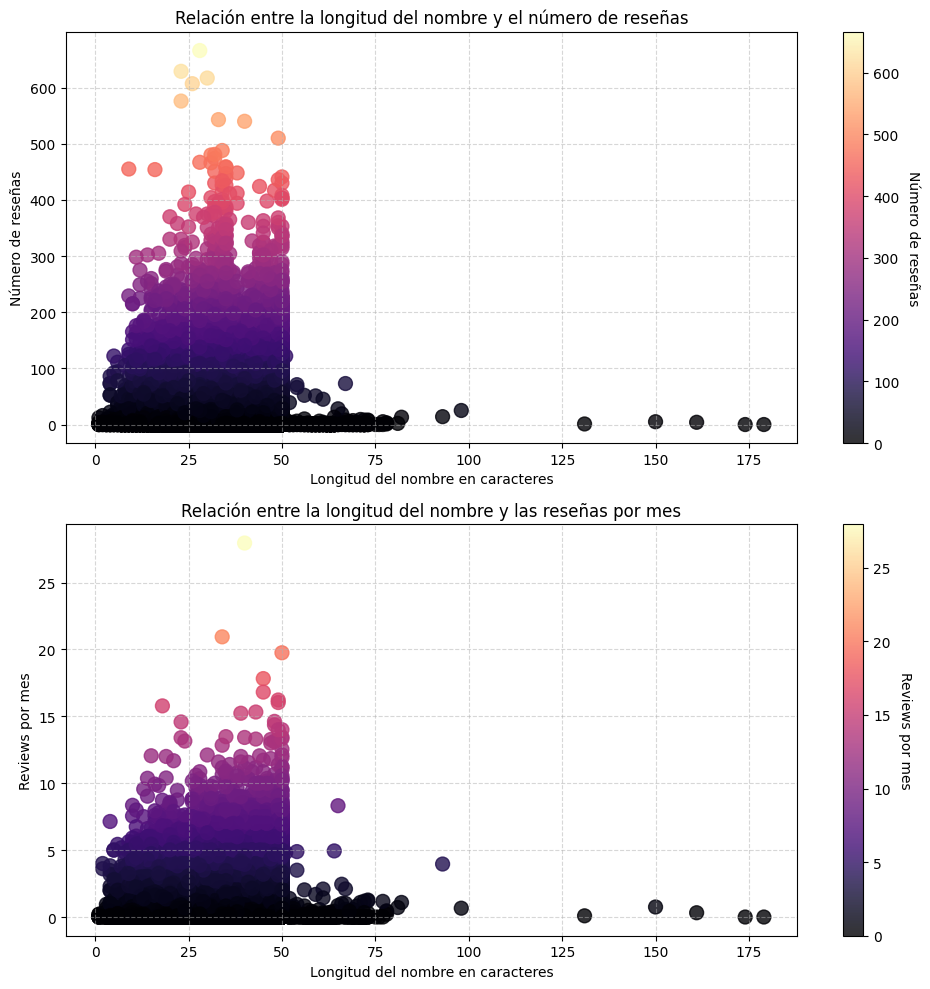

In [4]:
fig, axis = plt.subplots(2, 1, figsize=(10, 10))

# Number of reviews related with name leng
sc1 = axis[0].scatter(main_df['name_len'], main_df['number_of_reviews'], c=main_df['number_of_reviews'], cmap='magma', s=100, alpha=0.8)
cbar1 = fig.colorbar(sc1, ax=axis[0])
cbar1.set_label('Número de reseñas', rotation=270, labelpad=15)

axis[0].set_title('Relación entre la longitud del nombre y el número de reseñas')
axis[0].set_xlabel('Longitud del nombre en caracteres')
axis[0].set_ylabel('Número de reseñas')
axis[0].grid(True, linestyle='--', alpha=0.5)

# Reviews per month related with name leng
sc2 = axis[1].scatter(main_df['name_len'], main_df['reviews_per_month'], c=main_df['reviews_per_month'], cmap='magma', s=100, alpha=0.8)
cbar2 = fig.colorbar(sc2, ax=axis[1])
cbar2.set_label('Reviews por mes', rotation=270, labelpad=15)

axis[1].set_title('Relación entre la longitud del nombre y las reseñas por mes')
axis[1].set_xlabel('Longitud del nombre en caracteres')
axis[1].set_ylabel('Reviews por mes')
axis[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

En estos casos se puede apreciar una clara tendencia a la baja en cuanto a las reseñas para alojamientos con nombres muy largos, y también, aunque de un modo mucho más ligero, en los casos en los que los nombres son demasiado cortos.

<h3>Mapa de relación entre precio y ubicación del alojamiento</h3>

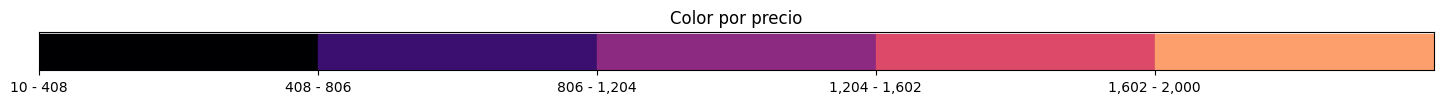

Map(center=[np.float64(40.73776), np.float64(-73.947445)], controls=(ZoomControl(options=['position', 'zoom_in…

In [5]:
reduced_df = main_df.sample(n=1000)

prices = reduced_df['price']
normalized_prices = (prices - prices.min()) / (prices.max() - prices.min())

cmap = plt.get_cmap('magma')
colors = [cmap(value) for value in normalized_prices]
hex_colors = ["#{:02x}{:02x}{:02x}".format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]

num_bins = 5
price_bins = np.linspace(reduced_df['price'].min(), reduced_df['price'].max(), num_bins + 1)
legend_colors = [cmap(i / num_bins) for i in range(num_bins)]
legend_hex_colors = [
    "#{:02x}{:02x}{:02x}".format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) 
    for c in legend_colors
]

plt.figure(figsize=(18, 0.5))
for i in range(num_bins):
    plt.fill_between([i, i+1], 0, 1, color=legend_hex_colors[i])
plt.xlim(0, num_bins)
plt.xticks(range(num_bins), [f"{int(price_bins[i]):,} - {int(price_bins[i+1]):,}" for i in range(num_bins)])
plt.yticks([])
plt.title("Color por precio")
plt.show()

locations = list(zip(reduced_df['latitude'], reduced_df['longitude']))

latitudes = reduced_df['latitude']
longitudes = reduced_df['longitude']
lat_min, lat_max = latitudes.min(), latitudes.max()
lon_min, lon_max = longitudes.min(), longitudes.max()
map_center = [(lat_min + lat_max) / 2, (lon_min + lon_max) / 2]

map = Map(center=map_center, zoom=12, min_zoom=1, max_zoom=20)

for i, each in enumerate(locations):
    circle = CircleMarker(
        location=list(each),
        radius=6,
        color=hex_colors[i],
        fill_color=hex_colors[i],
        fill_opacity=0.6
    )
    map.add_layer(circle)

map

In [6]:
le = LabelEncoder()

main_df['room_type'] = le.fit_transform(main_df['room_type'])
main_df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,name_len
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,1,149.0,1.0,9,2018-10-19,0.21,365.0,34
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,0,225.0,1.0,45,2019-05-21,0.38,355.0,21
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,1,150.0,3.0,0,NaN,0.00,365.0,35
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,0,89.0,1.0,270,2019-07-05,4.64,194.0,31
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,0,80.0,10.0,9,2018-11-19,0.10,0.0,48


<h3>Relación entre el precio del alojamiento y los demás datos</h3>

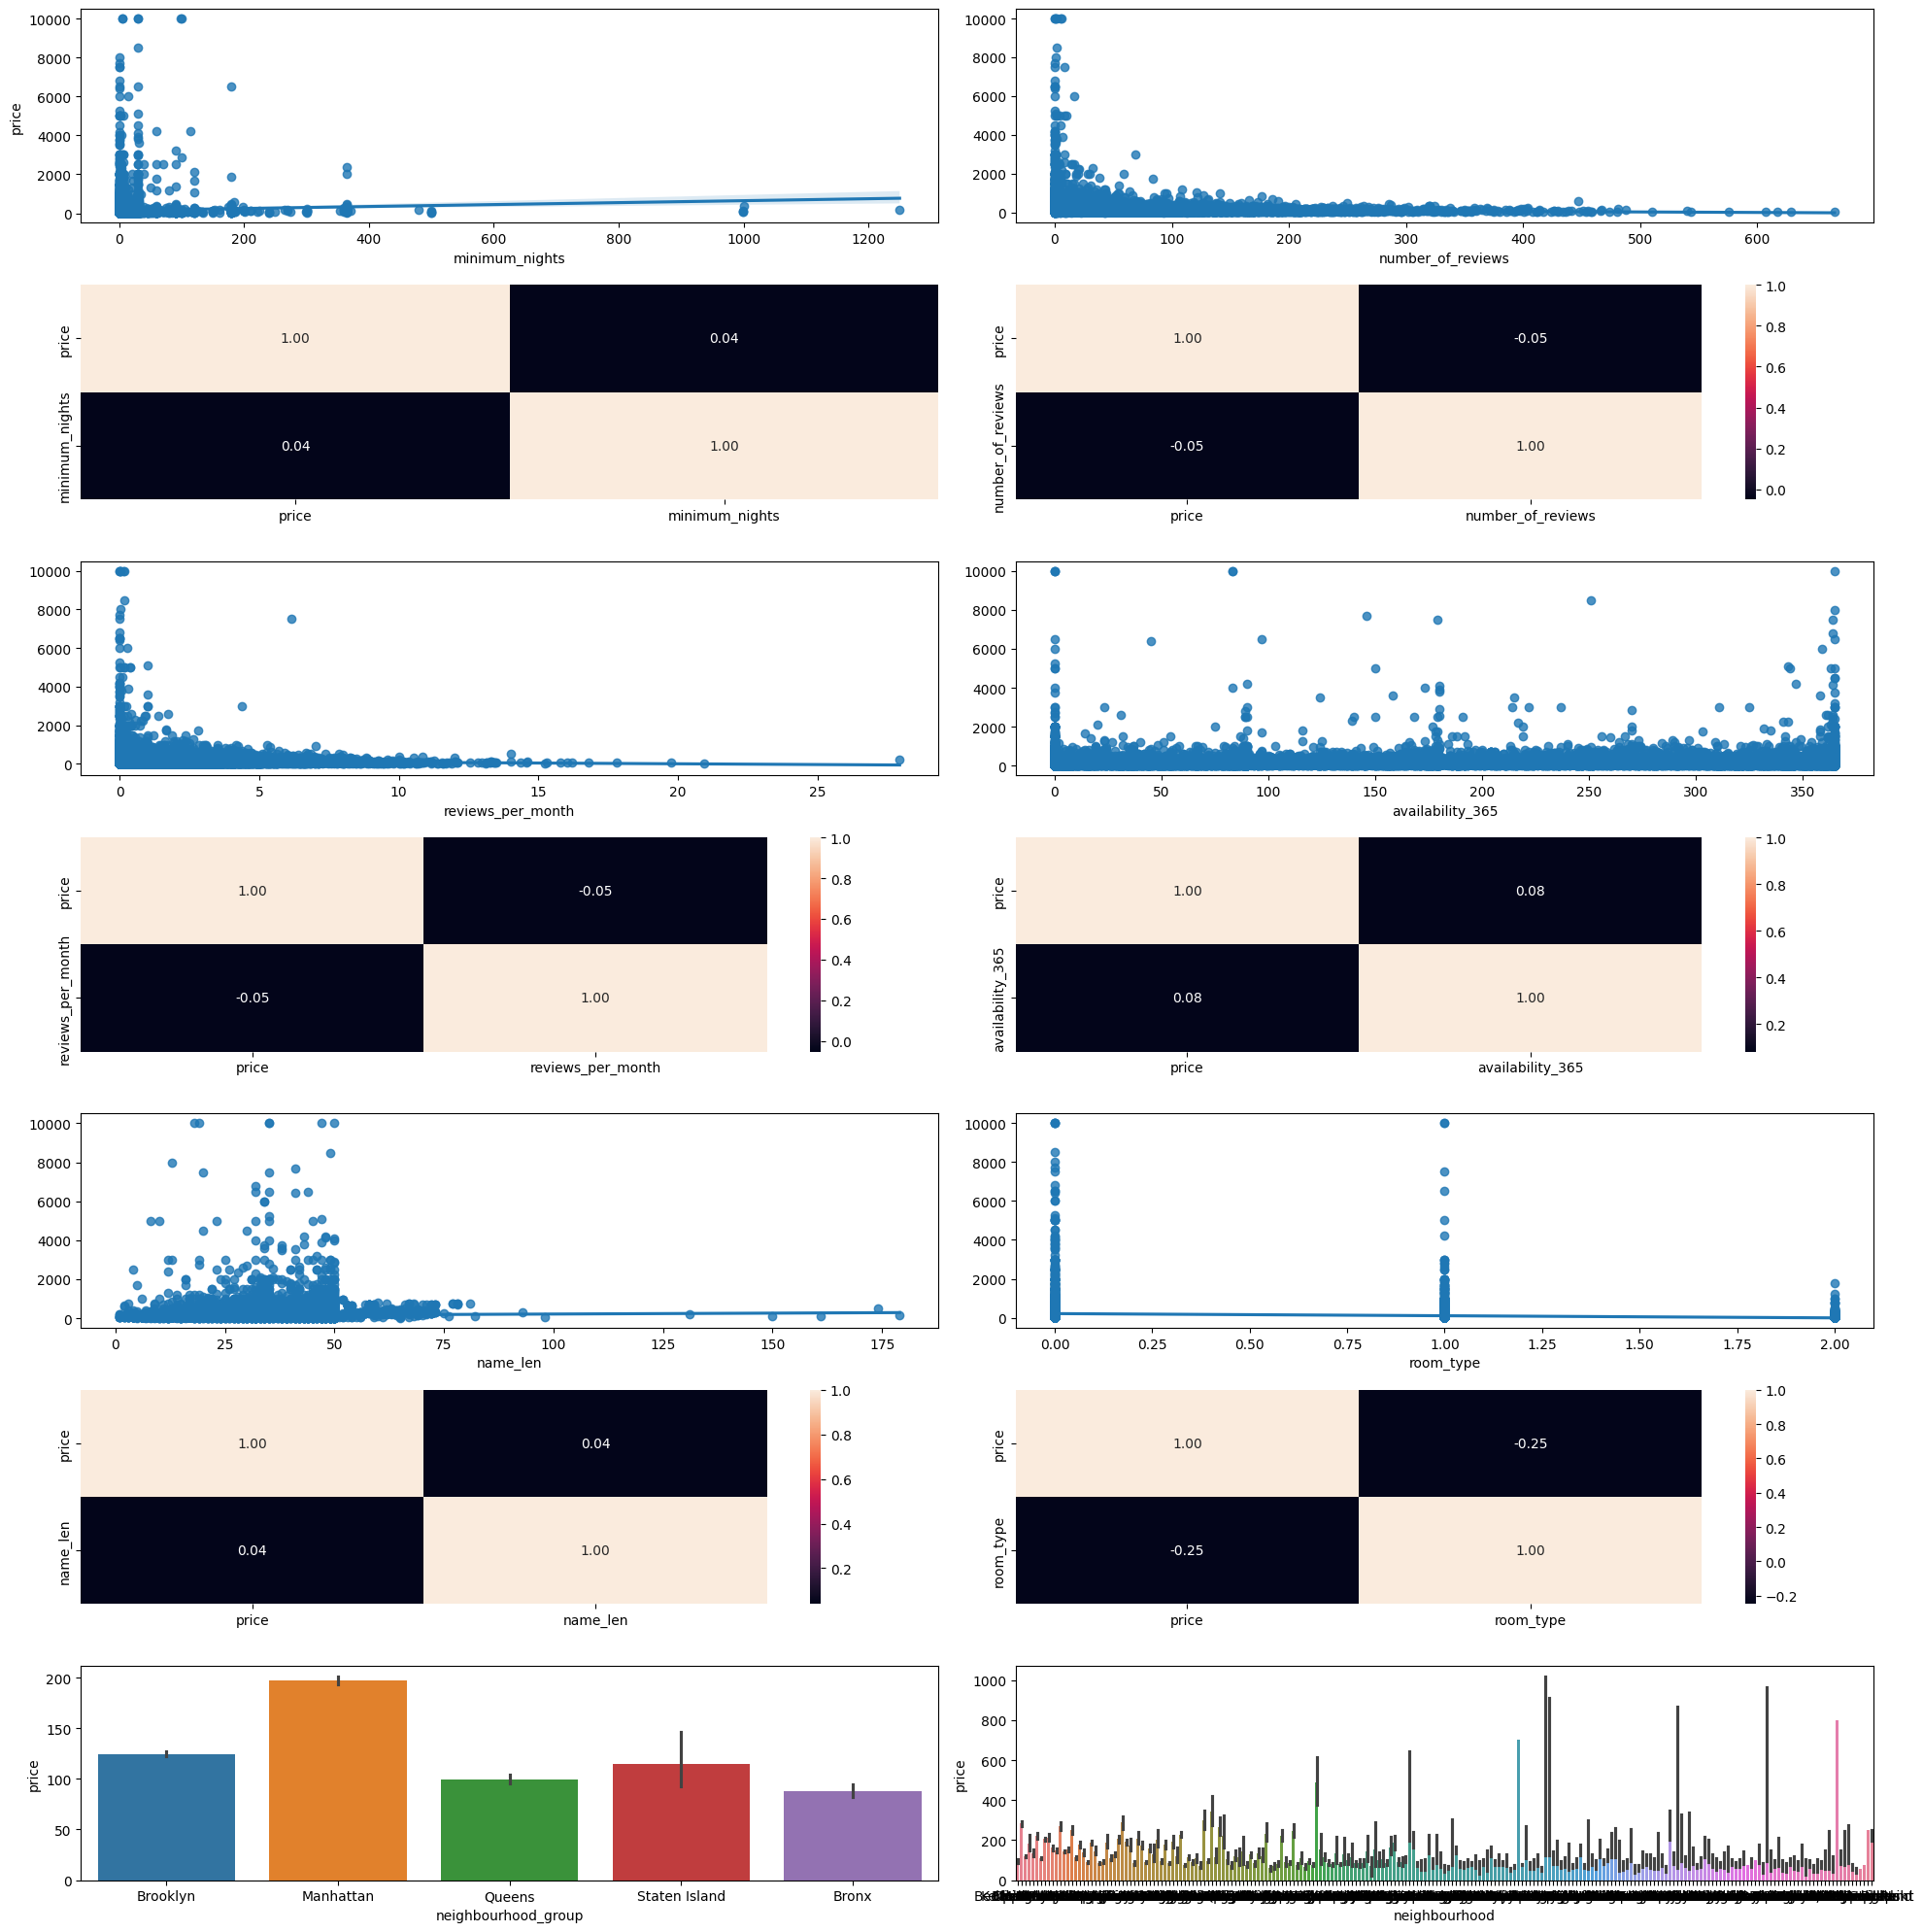

In [7]:
# Multivariate analysis
fig, axis = plt.subplots(7, 2, figsize = (20, 20))

# Numeric-numeric
sns.regplot(ax = axis[0, 0], data = main_df, x = "minimum_nights", y = "price")
sns.heatmap(main_df[["price", "minimum_nights"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = main_df, x = "number_of_reviews", y = "price").set(ylabel=None)
sns.heatmap(main_df[["price", "number_of_reviews"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2, 0], data = main_df, x = "reviews_per_month", y = "price").set(ylabel=None)
sns.heatmap(main_df[["price", "reviews_per_month"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0])

sns.regplot(ax = axis[2, 1], data = main_df, x = "availability_365", y = "price").set(ylabel=None)
sns.heatmap(main_df[["price", "availability_365"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1])

sns.regplot(ax = axis[4, 0], data = main_df, x = "name_len", y = "price").set(ylabel=None)
sns.heatmap(main_df[["price", "name_len"]].corr(), annot = True, fmt = ".2f", ax = axis[5, 0])

sns.regplot(ax = axis[4, 1], data = main_df, x = "room_type", y = "price").set(ylabel=None)
sns.heatmap(main_df[["price", "room_type"]].corr(), annot = True, fmt = ".2f", ax = axis[5, 1])

# Numeric-categorical
sns.barplot(ax = axis[6, 0], data = main_df, x = "neighbourhood_group", y = "price", hue = "neighbourhood_group")
sns.barplot(ax = axis[6, 1], data = main_df, x = "neighbourhood", y = "price", hue = "neighbourhood")

plt.tight_layout()
plt.show()

<h3>Relación entre la cantidad de reviews y los demás datos</h3>

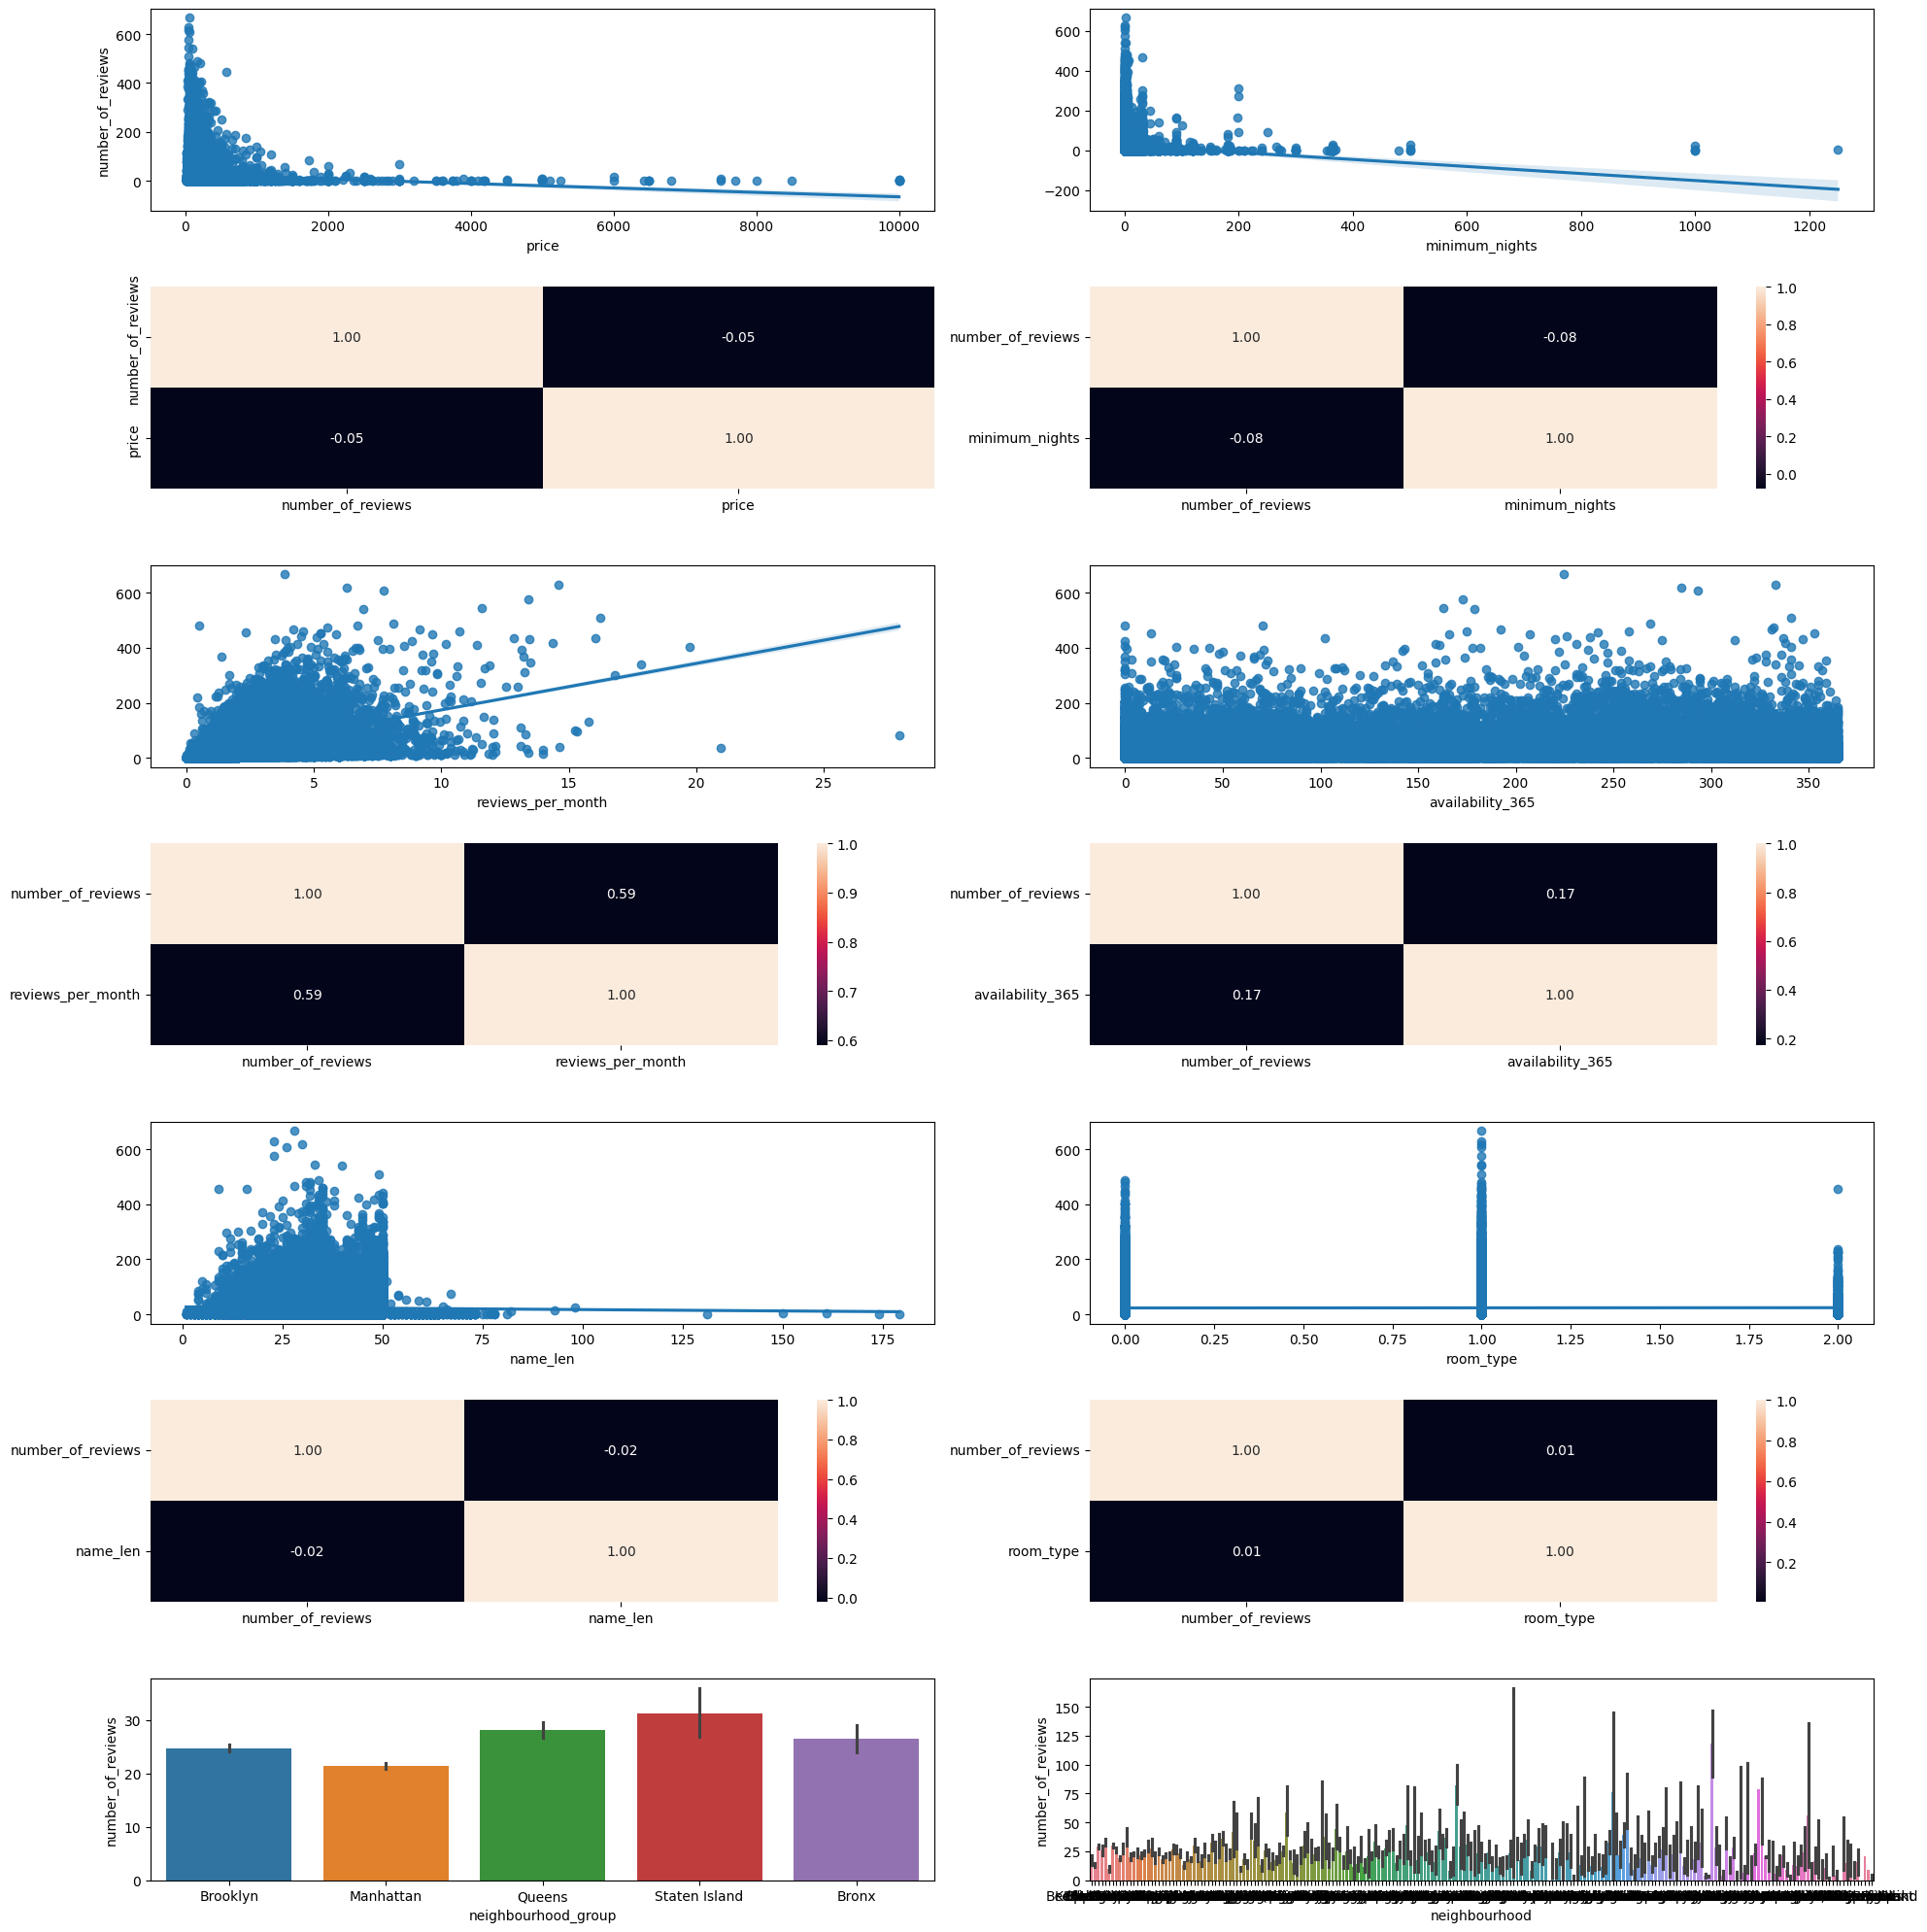

In [8]:
# Multivariate analysis
fig, axis = plt.subplots(7, 2, figsize = (20, 20))

# Numeric-numeric
sns.regplot(ax = axis[0, 0], data = main_df, x = "price", y = "number_of_reviews")
sns.heatmap(main_df[["number_of_reviews", "price"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = main_df, x = "minimum_nights", y = "number_of_reviews").set(ylabel=None)
sns.heatmap(main_df[["number_of_reviews", "minimum_nights"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2, 0], data = main_df, x = "reviews_per_month", y = "number_of_reviews").set(ylabel=None)
sns.heatmap(main_df[["number_of_reviews", "reviews_per_month"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0])

sns.regplot(ax = axis[2, 1], data = main_df, x = "availability_365", y = "number_of_reviews").set(ylabel=None)
sns.heatmap(main_df[["number_of_reviews", "availability_365"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1])

sns.regplot(ax = axis[4, 0], data = main_df, x = "name_len", y = "number_of_reviews").set(ylabel=None)
sns.heatmap(main_df[["number_of_reviews", "name_len"]].corr(), annot = True, fmt = ".2f", ax = axis[5, 0])

sns.regplot(ax = axis[4, 1], data = main_df, x = "room_type", y = "number_of_reviews").set(ylabel=None)
sns.heatmap(main_df[["number_of_reviews", "room_type"]].corr(), annot = True, fmt = ".2f", ax = axis[5, 1])

# Numeric-categorical
sns.barplot(ax = axis[6, 0], data = main_df, x = "neighbourhood_group", y = "number_of_reviews", hue = "neighbourhood_group")
sns.barplot(ax = axis[6, 1], data = main_df, x = "neighbourhood", y = "number_of_reviews", hue = "neighbourhood")

plt.tight_layout()
plt.show()

<h3>Dividir conjuntos de train y test</h3>

In [9]:
# Price as target variable
price_target = 'price'
features = ['neighbourhood_group',
            'neighbourhood',
            'room_type',
            'minimum_nights',
            'number_of_reviews',
            'reviews_per_month',
            'availability_365',
            'name_len'
            ]

X = main_df[features]
y = main_df[price_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.80)

In [10]:
# Number of reviews as target variable
reviews_target = 'number_of_reviews'
features = ['neighbourhood_group',
            'neighbourhood',
            'room_type',
            'price',
            'minimum_nights',
            'reviews_per_month',
            'availability_365',
            'name_len'
            ]

X = main_df[features]
y = main_df[price_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.80)